# 1. Daten Laden

In [6]:
# Bibliotheken laden
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dateien von Google Drive bereitstellen
from google.colab import drive
drive.mount('/content/drive')

# Excel auslesen
Datensatz = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Model Engineering/PSP_Jan_Feb_2019.xlsx',header = 0)
Datensatz = Datensatz.rename(columns = {"Unnamed: 0":"id"})

Mounted at /content/drive


# 2. Modellentwicklung & -bewertung

In [7]:
# Bilbiotheken laden
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import  precision_score,roc_curve,auc,accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score

def Visualisierung_AUC(model,x_test,y_test):
  # Berechnung der Falsch-Positiv-Rate und der Wahr-Positiv-Rate für alle Schwellenwerte der Klassifizierung
  probs = model.predict_proba(x_test)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)
  # Visualisierung
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def Visualisierung_Class_Errors(model,x_test,y_test):
  #Vorhersage
  y_pred = model.predict(x_test)
  #Zippe Daten in Liste
  list(zip(y_pred,y_test))
  #Entzippe Liste
  unzip_file = [{'y_pred':y_pred,'y_test':y_test}for y_pred,y_test in zip(y_pred,y_test)]
  #Estelle DataFrame
  data = pd.DataFrame(unzip_file)
  #Ermittel Classification Error
  data['class_error'] = abs(data.y_pred-data.y_test)
  data = pd.concat([data,x_test], axis=1, join="inner")
  data['zaehler'] = 1

  # Decode Features
  data['PSP'] = label_encoder_PSP.inverse_transform(data['PSP'])
  data['country'] = label_encoder_country.inverse_transform(data['country'])
  data['card'] = label_encoder_card.inverse_transform(data['card'])
  data['weekday'] = label_encoder_weekday.inverse_transform(data['weekday'])

  max = data.amount.max()

  def create_amount_quantiles(row):
    if row['amount'] > 0 and row['amount'] <= max/4:
      result = '0 - '+str(max/4)
    else:
      if row['amount'] > max/4 and row['amount'] <= max/4*2:
        result = str(max/4+1)+' - '+str(max/4*2)
      else:
        if row['amount'] > max/4*2 and row['amount'] <= max/4*3:
          result = str(max/4*2+1)+' - '+str(max/4*3)
        else:
          result = str(max/4*3+1)+' - '+str(max)
    return result

  data['amount_quantiles'] = data.apply(create_amount_quantiles, axis=1)


  field_list = ['PSP','card','country','weekday','3D_secured','amount_quantiles']
  error_rates = pd.DataFrame(columns=['Merkmal','Merkmalswert','class_error','zaehler'])

  for field in field_list:
    errors = data.groupby(data[field])['class_error'].sum()
    total = data.groupby(data[field])['zaehler'].sum()
    error_rates_tmp = pd.concat([errors, total], axis=1)
    error_rates_tmp['Merkmalswert'] = error_rates_tmp.index.values
    error_rates_tmp['Merkmal']=field
    error_rates_tmp.reset_index()
    error_rates = pd.concat([error_rates,error_rates_tmp])

  error_rates['class_error_rate'] = error_rates.zaehler/error_rates.class_error
  max_error_rate = error_rates['class_error_rate'].max()

  # Visualisiere Verteilungen
  fig = px.bar(error_rates, x='Merkmalswert', y='class_error_rate', color= 'Merkmal',labels={'class_error_rate':'Klassifizierungsfehler in %'},title="Fehlerrate Klassifizierungen")
  fig.add_hline(y=max_error_rate,line_dash="dot",annotation_text=str(round(max_error_rate,2))+' %',annotation_position="top left")
  fig.show()

def Model_Bewertung(model,x_train, y_train,x_test, y_test,X,Y):
  y_pred_proba = model.predict_proba(x_test)
  cross_validation_tmp = cross_val_score(model, X, Y, cv=6)
  cross_validation=[]
  for value in cross_validation_tmp:
    new = round(value,3)
    cross_validation.append(new)


  print('Bewertungsmetriken')
  print('#'*20)
  print(f"Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {round(model.score(x_train, y_train),2)}")
  print(f"Vorhersage-Genauigkeit auf Basis der Testdaten: {round(model.score(x_test, y_test),2)}")
  print('*'*15)
  precision_train = round(precision_score(y_train,model.predict(x_train),zero_division=1.0,average='weighted'),2)
  precision_test = round(precision_score(y_test,model.predict(x_test),zero_division=1.0,average='weighted'),2)
  print(f"Precision auf Basis der Trainingsdaten: {precision_train}")
  print(f"Precision auf Basis der Testdaten: {precision_test}")
  print('*'*15)
  f1_score_train = round(f1_score(y_train,model.predict(x_train),zero_division=1.0,average='weighted'),2)
  f1_score_test = round(f1_score(y_test,model.predict(x_test),zero_division=1.0,average='weighted'),2)
  print(f"F1-Score auf Basis der Trainingsdaten: {f1_score_train}")
  print(f"F1-Score auf Basis der Testdaten: {f1_score_test}")
  print('*'*15)
  print(f"Vorhersage-Genauigkeiten nach Kreuz-Validierung: {cross_validation}")
  print(f"Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: {round(sum(cross_validation)/len(cross_validation),3)}")

  print('*'*15)

# Datenaufbereitung
label_encoder_PSP = LabelEncoder()
label_encoder_country = LabelEncoder()
label_encoder_card = LabelEncoder()
label_encoder_weekday = LabelEncoder()

ML_Daten = Datensatz.filter(['amount','success','PSP','country','card','tmsp','3D_secured'], axis=1)

ML_Daten['country'] = label_encoder_country.fit_transform(ML_Daten['country'])
ML_Daten['PSP'] = label_encoder_PSP.fit_transform(ML_Daten['PSP'])
ML_Daten['card'] = label_encoder_card.fit_transform(ML_Daten['card'])

# Datumswerte in Tag/ Wochentag/ Stunde aufteilen
ML_Daten['weekday'] = ML_Daten['tmsp'].dt.day_name()
ML_Daten['weekday'] = label_encoder_weekday.fit_transform(ML_Daten['weekday'])
ML_Daten['day'] = ML_Daten['tmsp'].dt.strftime('%d').astype(int)
ML_Daten['hour'] = ML_Daten['tmsp'].dt.strftime('%H').astype(int)

# Separation in X Merkmale and Zielvariable Y
Y = ML_Daten['success']
X = ML_Daten.filter(['amount','PSP','3D_secured','card','country','weekday','day','hour'], axis=1)

# Aufteilung in Trainings- und Validierungsdatensatz
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## 2.1 RandomForest

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.96
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.76
***************
Precision auf Basis der Trainingsdaten: 0.96
Precision auf Basis der Testdaten: 0.68
***************
F1-Score auf Basis der Trainingsdaten: 0.96
F1-Score auf Basis der Testdaten: 0.71
***************
Vorhersage-Genauigkeiten nach Kreuz-Validierung: [0.785, 0.777, 0.791, 0.775, 0.785, 0.787]
Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.783
***************


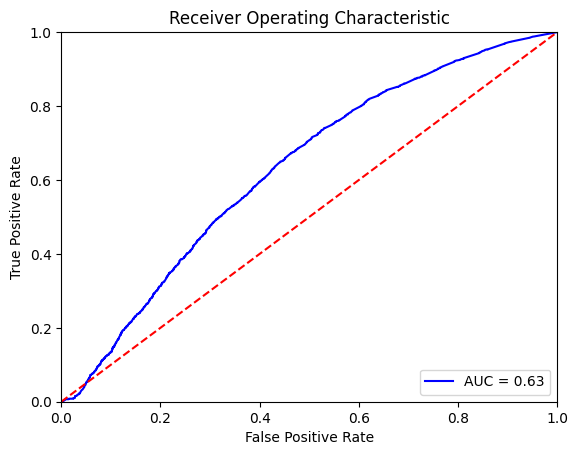

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

Model_Bewertung(rfc,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(rfc,x_test,y_test)
Visualisierung_Class_Errors(rfc,x_test,y_test)

## 2.2 Logistische Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.8
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.79
***************
Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84
***************
F1-Score auf Basis der Trainingsdaten: 0.71
F1-Score auf Basis der Testdaten: 0.7
***************
Vorhersage-Genauigkeiten nach Kreuz-Validierung: [0.797, 0.797, 0.797, 0.797, 0.797, 0.797]
Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.797
***************


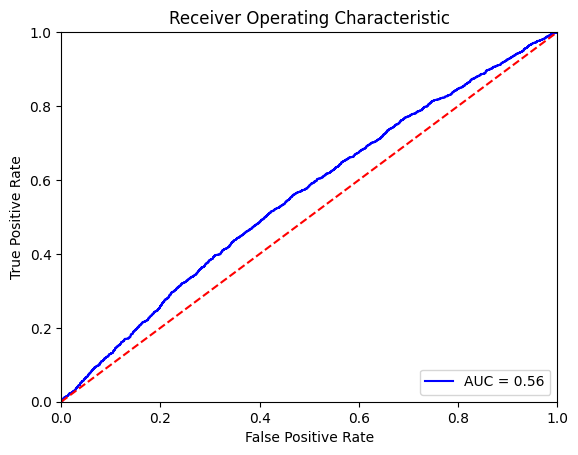

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

x_train_scaled = preprocessing.StandardScaler().fit(x_train)

lg = LogisticRegression(max_iter=10)
lg.fit(x_train, y_train)

Model_Bewertung(lg,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(lg,x_test,y_test)
Visualisierung_Class_Errors(lg,x_test,y_test)

## 2.3 KNN

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.82
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.77
***************
Precision auf Basis der Trainingsdaten: 0.8
Precision auf Basis der Testdaten: 0.68
***************
F1-Score auf Basis der Trainingsdaten: 0.77
F1-Score auf Basis der Testdaten: 0.71
***************
Vorhersage-Genauigkeiten nach Kreuz-Validierung: [0.762, 0.758, 0.76, 0.751, 0.762, 0.768]
Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.76
***************


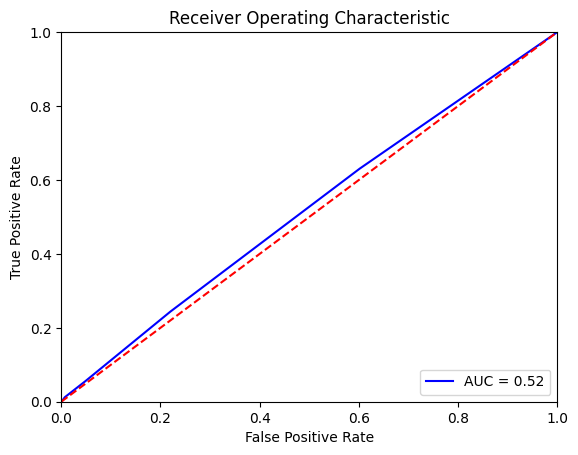

In [12]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)

Model_Bewertung(KNN,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(KNN,x_test,y_test)
Visualisierung_Class_Errors(KNN,x_test,y_test)

## 2.4 Support Vektor Machine

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

SVC = SVC(kernel='linear',probability=True)
SVC.fit(x_train, y_train)

Model_Bewertung(SVC,x_train, y_train,x_test, y_test)
Visualisierung_AUC(SVC,x_test,y_test)
Visualisierung_Class_Errors(SVC,x_test,y_test)

NameError: ignored

# 3 Bestes Modell feintunen

In [15]:
# 1) Merkmale reduzieren anhand Erkenntissen aus EDA und Separation in X Merkmale and Zielvariable Y
X2 = ML_Daten.filter(['amount','PSP','3D_secured'], axis=1)
# Neue Aufteilung in Trainings- und Validierungsdatensatz
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=0.2)

# Modell trainieren
rfc_final = RandomForestClassifier()
rfc_final.fit(x_train2,y_train2)
#Bewertung
Model_Bewertung(rfc_final,x_train2, y_train2,x_test2, y_test2,X,Y)

rfc_final.get_params()

#Hyperparameter-Tuning mittels Kreuz-Validierung
# Validiere Model mit verschiedenen HP-Eintellungen

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.81
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.78
***************
Precision auf Basis der Trainingsdaten: 0.79
Precision auf Basis der Testdaten: 0.71
***************
F1-Score auf Basis der Trainingsdaten: 0.75
F1-Score auf Basis der Testdaten: 0.72
***************
Vorhersage-Genauigkeiten nach Kreuz-Validierung: [0.784, 0.779, 0.792, 0.777, 0.79, 0.79]
Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.785
***************


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
import numpy as np

# Hyper-Parameter für Raster
# Anzahl an Bäumen im RandomForest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Azahl der betrachteten Merkmale für jede Aufteilung
max_features = ['auto','sqrt']
# Maximale Anzahl an Ebenen in einem Baum
max_depth = [2,4]
# Minimale Anzahl der Proben, die zum Teilen eines Knotens erforderlich sind
min_samples_split = [2,5]
# Minimale Anzahl der Proben, die für jeden Knoten erforderlich sind
min_samples_leaf = [1,2]
#Bootstrap-Method zur Zusammenstellung der Trainingsdaten für jeden Baum verwenden - Ja/ Nein
bootstrap = [True, False]

# Erzeugen eines zufälligen Parameter-Rasters
param_grid= {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rfc_final, param_grid = param_grid, cv = 6, verbose=2, n_jobs = 4)
rf_Grid.fit(x_train2,y_train2)
rf_Grid.best_params_
#Bewertung der ermittelten optimalen HP
print(f'Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {rf_Grid.score(x_train2,y_train2):.3f}')
print(f'Vorhersage-Genauigkeit auf Basis der Testdaten: {rf_Grid.score(x_test2,y_test2):.3f}')


#Bewertung mit optimierten Hyperparameter


# GGf. Regularisierung bei Overfit integrieren


# Modell finale mit allen Daten trainieren
#rfc_final.fit(X2,Y)

#Finale Bewertung
#Model_Bewertung(rfc_final,x_train2, y_train2,x_test2, y_test2)

Fitting 6 folds for each of 320 candidates, totalling 1920 fits
